In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn.metrics as metric
import warnings
from sklearn.utils import shuffle
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
%matplotlib inline 

In [26]:
#Checking for gpu device
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
parent_dir = '/kaggle/input/vegetable-image-dataset/Vegetable Images'
train_dir = os.path.join(parent_dir, 'train')
test_dir = os.path.join(parent_dir, 'test')
valid_dir = os.path.join(parent_dir, 'validation')

In [4]:
#Directories of images
train_dirs = os.listdir(train_dir)
print(f'Folder count in train_dirs - {len(train_dirs)}')
test_dirs = os.listdir(test_dir)
print(f'Folder count in test_dirs - {len(test_dirs)}')
valid_dirs = os.listdir(valid_dir)
print(f'Folder count in valid_dirs - {len(valid_dirs)}')

Folder count in train_dirs - 15
Folder count in test_dirs - 15
Folder count in valid_dirs - 15


In [31]:
#15 different types of vegetables
os.listdir(train_dir)

['Broccoli',
 'Capsicum',
 'Bottle_Gourd',
 'Radish',
 'Tomato',
 'Brinjal',
 'Pumpkin',
 'Carrot',
 'Papaya',
 'Cabbage',
 'Bitter_Gourd',
 'Cauliflower',
 'Bean',
 'Cucumber',
 'Potato']

In [5]:
def imagesLabels(dirs,dir_):
    image_path = []
    label = []
    for di in dirs:
        for path in os.listdir(dir_+'/'+di):
            image_path.append(dir_+'/'+di+'/'+path)
            label.append(di)
    return image_path, label

In [6]:
train_Im, train_Lb = imagesLabels(train_dirs,train_dir)
test_Im, test_Lb = imagesLabels(test_dirs,test_dir)
val_Im, val_Lb = imagesLabels(valid_dirs,valid_dir)

In [7]:
train_df = pd.DataFrame(list(zip(train_Im, train_Lb)),columns = ['Filepath', 'Labels'])
train_df.head()

,Filepath,Labels
0,/kaggle/input/vegetable-image-dataset/Vegetabl...,Broccoli
1,/kaggle/input/vegetable-image-dataset/Vegetabl...,Broccoli
2,/kaggle/input/vegetable-image-dataset/Vegetabl...,Broccoli
3,/kaggle/input/vegetable-image-dataset/Vegetabl...,Broccoli
4,/kaggle/input/vegetable-image-dataset/Vegetabl...,Broccoli


In [8]:
val_df = pd.DataFrame(list(zip(val_Im, val_Lb)),columns = ['Filepath', 'Labels'])
test_df = pd.DataFrame(list(zip(test_Im, test_Lb)),columns = ['Filepath', 'Labels'])

In [9]:
veg_list = list(train_df['Labels'].unique())
veg_dict = dict(zip(veg_list,range(len(veg_list))))

In [10]:
def shuffle_label(df):
    """
    Function to shuffle and replace categories with numbers
    """
    #df['Labels'] = df['Labels'].replace(veg_dict)
    df = shuffle(df)
    df.reset_index(inplace=True)
    df.drop('index',axis=1,inplace=True)
    return df

In [11]:
train_df = shuffle_label(train_df)
val_df = shuffle_label(val_df)
test_df = shuffle_label(test_df)

### Plotting the first 9 vegetable images

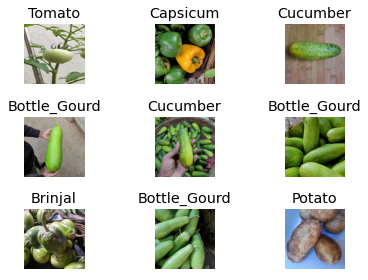

In [12]:
f,a = plt.subplots(nrows=3, ncols=3,subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(train_df.Filepath[i]))
    ax.set_title(train_df.Labels[i])
    #ax.set_title(list(veg_dict.keys())[list(veg_dict.values()).index(train_df.Labels[i])])
    
plt.tight_layout()
plt.show()

### Image generator to augment training images and just rescale test and validation images

In [13]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')
val_test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [14]:
x_train =  train_gen.flow_from_dataframe(dataframe = train_df,  x_col='Filepath', y_col='Labels',target_size=(224, 224))
x_val =  val_test_gen.flow_from_dataframe(dataframe = val_df,  x_col='Filepath', y_col='Labels',target_size=(224, 224))
x_test =  val_test_gen.flow_from_dataframe(dataframe = test_df,  x_col='Filepath', y_col='Labels',target_size=(224, 224))

Found 15000 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.


In [20]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(224, 224, 3)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(15,activation='softmax'))
    
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
# Defining and early stopping criteria to avoid overfitting. If for 2 epochs the val loss increases then model stops training.
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 2)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 52, 52, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 173056)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               2

In [23]:
network = model.fit(x_train,
                    epochs=10,
                    steps_per_epoch = 200,
                    validation_data=x_val,
                    callbacks = [early_stopping])

2021-12-31 10:01:06.391571: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
200/200 [==============================] - 322s 2s/step - loss: 2.0746 - accuracy: 0.3223 - val_loss: 1.4615 - val_accuracy: 0.5213
Epoch 2/10
200/200 [==============================] - 289s 1s/step - loss: 1.3427 - accuracy: 0.5472 - val_loss: 1.2871 - val_accuracy: 0.5743
Epoch 3/10
200/200 [==============================] - 284s 1s/step - loss: 1.1123 - accuracy: 0.6291 - val_loss: 0.9604 - val_accuracy: 0.6820
Epoch 4/10
200/200 [==============================] - 280s 1s/step - loss: 0.9822 - accuracy: 0.6788 - val_loss: 0.6734 - val_accuracy: 0.7893
Epoch 5/10
200/200 [==============================] - 275s 1s/step - loss: 0.8851 - accuracy: 0.7117 - val_loss: 0.7791 - val_accuracy: 0.7443
Epoch 6/10
200/200 [==============================] - 276s 1s/step - loss: 0.7636 - accuracy: 0.7458 - val_loss: 0.6388 - val_accuracy: 0.7937
Epoch 7/10
200/200 [==============================] - 275s 1s/step - loss: 0.7266 - accuracy: 0.7661 - val_loss: 0.6566 - val_accuracy: 0.7817

In [24]:
test_loss,test_acc = model.evaluate(x_test)

94/94 [==============================] - 38s 399ms/step - loss: 0.4947 - accuracy: 0.8420


In [25]:
print(f"The accuracy for testing is {round(test_acc,2) * 100} % ")

The accuracy for testing is 84.0 % 


## This model is giving us 84.0 % test accuracy. It is performing quite good. 
## As there is no class imbalance so high accuracy can be a good metric.

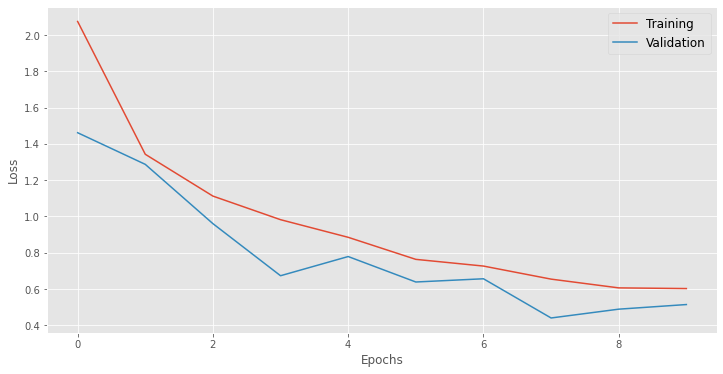

In [27]:
plt.figure(figsize=(12,6))
plt.plot(network.history['loss'],label = 'Training')
plt.plot(network.history['val_loss'],label = 'Validation')
plt.legend(loc='best',fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Loss");

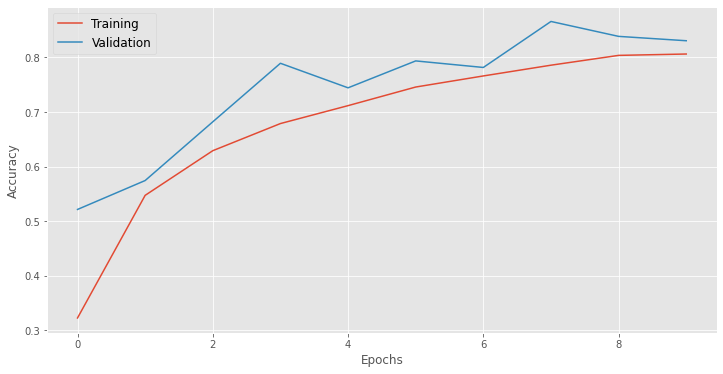

In [28]:
plt.figure(figsize=(12,6))
plt.plot(network.history['accuracy'],label = 'Training')
plt.plot(network.history['val_accuracy'],label = 'Validation')
plt.legend(loc='best',fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Accuracy");

In [30]:
# Saving our model
model.save("veg_classifier_model.h5")